In [1]:

# coding: utf-8

# # Load libraries

# In[1]:
'''
On Bracewell, load these commands below:
module load tensorflow/1.14.0-py36-gpu
module load cuda/9.0.176
module load cudnn/v6
python 3D-FCN2-ECCV-data-Chuong_onroad.py
'''

import re
import cv2
import numpy as np
import os
import datetime
import math
import zedutils
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tqdm import tqdm

from plane_fitting import fitPlane, getInliers, getHorizonLine, track3D_img, track3D_mask, fitPlaneCorr
from utilities import getStereoDisparity
#switch between on road data and off road data
ROOT = '../data/'
WORK_ON = 'on_road' #'on_road' #'off_road' #
NETWORK = '3D-FCN2' #'3D-FCN'
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# # Load data

map1x, map1y, map2x, map2y, mat, Q1 = \
                zedutils.getTransformFromConfig('SN1994.conf', Type='CAM_HD')

Q = np.array([[1, 0, 0, -6.57925000e+02],
             [0, 1, 0, -3.78654000e+02],
             [0, 0, 0, 6.99943000e+02],
             [0, 0, 1/120., 0]])

# In[2]:
def rebin(arr, new_shape):
    '''
    Source: https://scipython.com/blog/binning-a-2d-array-in-numpy/
    '''
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


def rebin_image2D(arr, bin_size):
    '''
    Modified version of rebin to accept bin_size instead of new_shape
    '''
    shape = (arr.shape[0] // bin_size[0], bin_size[0],
             arr.shape[1] // bin_size[1], bin_size[1])
    return arr.reshape(shape).mean(axis=(-1, 1))


def rebin_image3D(img, bin_size=(2, 2)):
    '''
    Bin images according to bin_size
    '''
    img_bin = np.stack([rebin_image2D(img[:, :, i].astype(np.float32), bin_size) for i in range(img.shape[2])],
                       axis=2)

    return img_bin


def warp_transformation():
    IMAGE_H=100
    IMAGE_W=320
    img = X_train[60][0]
    #img = img[100:240, 0:320]
    src = np.float32([[0, 240], [IMAGE_W, 240], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[100, 240], [220, 240], [0, 0], [IMAGE_W, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, 240)) # Image warping
    im1_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(warped_img,cv2.COLOR_BGR2GRAY)
    sz = img.shape
    warp_mode = cv2.MOTION_HOMOGRAPHY
    warp_matrix = np.eye(3, 3, dtype=np.float32)
    number_of_iterations = 5000
    termination_eps = 1e-10
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    (cc, warp_matrix) = cv2.findTransformECC (im2_gray,im1_gray,warp_matrix, warp_mode, criteria)

def load_dataset_path(txt_path):
    p = np.genfromtxt(txt_path, dtype='str')
    return p[:, 1]

def logTransform(c, f):
    g = c * math.log(float(1 + f), math.e)
    return g

def logTransformImage(image, outputMax = 255, inputMax = 255):
    c = 255 / np.log(1 + np.max(image))
    image = image + 1
    image = np.where(image<1, 255, image)
    log_image = c * (np.log(image))

    # Specify the data type so that
    # float value will be converted to int
    log_image = np.array(log_image, dtype = np.uint8)
    return log_image

    
def bird_eye(image, warpMatrix):
    image = image[100:240, 0:320]
    sz = image.shape
    warpped_img = cv2.warpPerspective (image, warpMatrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return warpped_img

def get_bird_eye(pair, mask_gt, ismask):
    im1_c = pair[:, :pair.shape[1]//2, :]
    im2_c = pair[:, pair.shape[1]//2:, :]
    im1_rec = cv2.remap(im1_c, map1x, map1y,
                                        cv2.INTER_CUBIC)
    im2_rec = cv2.remap(im2_c, map2x, map2y,
                        cv2.INTER_CUBIC)
    pair = np.concatenate((im1_rec, im2_rec), axis=1)
    
    leftBGR = pair[:, :pair.shape[1]//2, :]
    rightBGR = pair[:, pair.shape[1]//2:, :] 
    maxDisparity = 32
    disp = getStereoDisparity(pair, dispRange=[0, maxDisparity])
    if 'u' not in globals():
        # inialise these variables
        u, v = np.meshgrid(np.arange(disp.shape[1]),
                            np.arange(disp.shape[0]))
    groundCoefs, mask = fitPlane(u, v, disp, skip=10, infHeight=350)
    d = groundCoefs[0]*u + groundCoefs[1]*v + groundCoefs[2]
    d[d < 0] = 0
    mask = getInliers(u, v, d, disp, tolerance=np.array([1, 0.05]))
    mask[:400, :] = False

    mask2 = np.logical_not(mask)
    disp2 = np.copy(disp)
    disp2[mask2] = 0
    disp3 = np.copy(disp)
    disp3[mask] = 0
    
    infHeight = 400
    w, h, dmax = 1.0, 1.0, 1.0
    v0 = h*infHeight/d.shape[0] #
    u0, v0, d0 = [w/2.0, v0, 0.0]
    u1, v1, d1 = [w/2.0, h, dmax]
    u2, v2, d2 = [0.0, v0, 0.0]
    a = -d1*(v2-v0)/u0/(v1-v0)
    b = d1/(v1-v0)
    c = d1*(v2-2.0*v0)/(v1-v0)

    x0 = np.array([a, b, c])

    groundCoefs2 = fitPlaneCorr([groundCoefs[0], groundCoefs[1], groundCoefs[2]/1000], leftBGR, rightBGR, mask)
    groundCoefs2[2] *= 1000
    #print(groundCoefs, groundCoefs2)
    ROIXZ=[-10., 10., 0.5, 20.]
    if ismask:
        return track3D_mask(mask_gt[:,:,0], groundCoefs2, disp, Q, ROIXZ)
    else:

        return track3D_img(leftBGR, groundCoefs2, disp, Q, ROIXZ)
    
    
def load_data_bothroad(img_folder, txt_path, resize_by, num_frames=8, skipping=False):
    # load ZED camera config and
    # obtain stereo rectification maps, camera matrix and Q matrix
    # default is skipping to
    map1x, map1y, map2x, map2y, mat, Q = zedutils.getTransformFromConfig('SN1994.conf', Type='CAM_HD')
    stereo = cv2.StereoSGBM_create(0, 32, 19, speckleWindowSize=100, speckleRange=2)
    X = []
    Y = []
    mask_file_names = load_dataset_path(txt_path)

    for mask_file_name in tqdm(mask_file_names):
        file_num = int(re.findall('\d+', mask_file_name )[0])
        if 'on_road' in mask_file_name:
            fname = '../Dataset/masks/on_road/left_mask_%09d.png' % (file_num)
            img_folder = '../Dataset/video_on_road/'
        else:
            fname = '../Dataset/masks/off_road/left_mask_%09d.png' % (file_num)
            #img_folder = '../Dataset/video_off_road/'
            img_folder = '../Dataset/bird_eye_out/'
        mask = cv2.imread(fname, 0)
        #print('mask shape: ',mask.shape)
        if skipping:
            mask = mask[::resize_by[0], ::resize_by[1]]
        else:
            mask = np.uint8(rebin_image2D(mask, resize_by))
           # mask = bird_eye(mask, warp_matrix)
            mask[mask>127] = 255
            mask[mask<=127] = 0
       # print(mask.min())
        
        #print(mask.shape)
        Y.append(mask.flatten())
        #load mask to Y
       # print('mask shape: ', mask.shape)
        
        #load num_frames before truth mask.
        video = []
        i = 0
        for j in range(file_num-num_frames+1,file_num+1):
            image_file_name = os.path.join(img_folder, 'img_%09d.ppm' % j)
            #print(image_file_name)
            #load pair
            pair = cv2.imread(image_file_name)
            frame_left = pair.copy()
            frame_left_rec = frame_left #cv2.remap(frame_left, map1x, map1y, cv2.INTER_CUBIC)
            #resize
#             if skipping:
#                 frame_left_rec = frame_left_rec[::resize_by[0], ::resize_by[1], :]
#             else: # binning
#                 frame_left_rec = np.uint8(rebin_image3D(frame_left_rec, resize_by))

            #images form a video
            video.append(frame_left_rec)

        X.append(video)
        
    return np.array(X),np.array(Y)# In[5]:


# In[6]:


#One hot encoding for each pixel
def one_hot(Y):
    result = []
    for i in tqdm(range(len(Y))):
        img_array = []
        for j in range(len(Y[i])):
            e = Y[i][j]
            if e == 255:
                img_array.append(np.array([0,1]))
            elif e == 0:
                img_array.append(np.array([1,0]))
        result.append(img_array)
    return np.array(result)


outfile = os.path.join('../Dataset/'+WORK_ON+'_data.npz')
if os.path.exists(outfile)==False:
    print('Read '+'../Dataset/'+WORK_ON+'_train.txt')
    X_train,y_train = load_data_bothroad('../Dataset/video_'+WORK_ON, '../Dataset/'+WORK_ON+'_train.txt', resize_by=(3,4))
    print('Read '+'../Dataset/'+WORK_ON+'_test.txt')
    X_test, y_test  = load_data_bothroad('../Dataset/video_'+WORK_ON, '../Dataset/'+WORK_ON+'_test.txt', resize_by=(3,4))
    print('Convert to one hot')
    y_train = one_hot(y_train)
    y_test  = one_hot(y_test)
    print('Saved precomputed data to %s' % outfile)
    np.savez(outfile, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
else:
    print('Load precomputed data file %s' % outfile)
    npzfile = np.load(outfile)
    X_train = npzfile['X_train']
    y_train = npzfile['y_train']
    X_test = npzfile['X_test']
    y_test = npzfile['y_test']

image_shape = X_train.shape[2:]
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

# In[8]:


#shows a random video with its mask
def show_data(X, Y_true, Y_pred = None):
    #de-one-hot
    Y_true = np.array(Y_true.argmax(axis=2) * 255,dtype=np.uint8)
    #random show a pair of video & mask
    n = np.random.randint(X.shape[0])
    images,msk = X[n],Y_true[n]
    for i,image in enumerate(images):
        cv2.putText(image,
                    str(i),
                    (10, image.shape[0]-15),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
        cv2.imshow("images",image)
        if i == len(images) - 1:
            cv2.imshow("true_mask",msk.reshape(image_shape[0:2]))
            if Y_pred is not None:
                Y_pred = np.array(Y_pred.argmax(axis=2) * 255,dtype=np.uint8)
                msk_pred = Y_pred[n]
                cv2.imshow("pred_mask", msk_pred.reshape(image_shape[0:2]))
        cv2.waitKey(0)
    cv2.destroyAllWindows()

#show_data(X_train,y_train)

# choose GPU
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]="1";  

# # Load Model

# In[9]:

from tensorflow.keras import backend
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


n_classes = 2
input_shape = X_train.shape[1:]
img_input = Input(shape=(input_shape),name='input')
kernel_size = (3,3,3)
pool_size = (2,2,2)
#kernel_size = (3,3)
#pool_size = (2,2)

#strides_size = (2,2,2)
filter_size = 64


# In[10]:

# In[10]:
def conv3d_bn(x, filters, num_row, num_col, num_z, padding='same', strides=(1, 1, 1), activation='relu', name=None):

    x = Conv3D(filters, (num_row, num_col, num_z), strides=strides, padding=padding, use_bias=False)(x)
    x = tfa.layers.GroupNormalization(groups=32, axis=4)(x)

    if(activation==None):
        return x

    x = Activation(activation, name=name)(x)
    return x


def ResBlock(U, inp):
    shortcut = inp
    shortcut = conv3d_bn(shortcut, U, 1, 1, 1, activation=None, padding='same')
    conv3x3 = conv3d_bn(inp, U, 3, 3, 3, activation='relu', padding='same')
    conv5x5 = conv3d_bn(conv3x3, U, 3, 3, 3, activation='relu', padding='same')
    #out = BatchNormalization(axis=4)(conv5x5)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(conv5x5)
    
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)

    return out
    
def CSPRes(U, inp, pool_size):
    part1 = inp
    part1 = conv3d_bn(part1, U//2,  1, 1, 1, activation='relu', padding='same')
    par1 = tfa.layers.GroupNormalization(groups=32, axis=4)(part1)
    part2 = ResBlock(U//2, inp)
    
    out = tf.keras.layers.concatenate([part1, part2], axis=4)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)
    return out
    
    

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv3d_bn(shortcut, filters , 1, 1, 1, activation=None, padding='same')

    out = conv3d_bn(inp, filters, 3, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv3d_bn(shortcut, filters , 1, 1, 1, activation=None, padding='same')

        out = conv3d_bn(out, filters, 3, 3, 3, activation='relu', padding='same')        

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)


    return out

def make_model(input_shape, n_classes, filter_size, kernel_size, pool_size):
    #This code structure is based on Image Segmentation Keras by divamgupta.
    #https://github.com/divamgupta/image-segmentation-keras
    img_input = Input(shape=(input_shape),name='input')
    #Block1
    part1, part2 = tf.split(img_input, 2, 1)
    part1 = ResBlock(filter_size, part1) 
    part2 = conv3d_bn(part2, filter_size, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    x = concatenate([part1, part2],axis=1)
    x = tfa.layers.GroupNormalization(groups=32)(x)
    #x = BatchNormalization(name='bn1')(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block1_pool1')(x)
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResPath(filter_size, 2, part1)
    part2 = conv3d_bn(part2, filter_size, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    f1 = concatenate([part1,part2],axis=1)
    #Block2
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResBlock(filter_size, part1)
    x = concatenate([part1,part2],axis=1)
    
    x = tfa.layers.GroupNormalization(groups=32)(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block2_pool1')(x)
    
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResPath(filter_size*2,1, part1)
    part2 = conv3d_bn(part2, filter_size*2, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    f2 = concatenate([part1,part2],axis=1)
    #Block3
    x = CSPRes(filter_size*4, x, pool_size) 
    x = tfa.layers.GroupNormalization(groups=32)(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block3_pool1')(x)
    f3 = x

    f3_shape = Model(img_input,f3).output_shape
    o = f3
    o = Reshape(f3_shape[2:],name='reshape1')(o) # remove the first dimension as it equals 1
    #Extract feature
    o = Conv2D(filters = 2048, kernel_size = (7,7), activation='relu', padding = 'same', data_format = 'channels_last',name='increase_conv1')(o)
    o = Dropout(0.5,name='drop1')(o)
    o = Conv2D(filters = 2048, kernel_size = (1,1), activation='relu', padding = 'same', data_format = 'channels_last',name='increase_conv2')(o)
    o = Dropout(0.5,name='drop2')(o)
    #Predict layer
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv1')(o)

    #Deconv by 2 for adding.
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv1')(o)
    #Features from f2 layer
    o1 = f2
   
    o1 = AveragePooling3D(pool_size = (2,1,1))(o1)
  
    o1 = Reshape((60,80,128))(o1)
    #print(o1.shape)
    ##############################
    #Respath block
    #o1 = ResPath(n_classes, 2, o1)
    o1 = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv2')(o1)
    
    o = concatenate([o,o1],axis=3)
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='concat1_conv')(o)
    #Deconv by 4->2
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv2')(o)

    #feature from f1 layer
    o2 = f1
    #print(o2.shape)
    #o2 = Lambda(lambda x:x[:,-1,:,:,:], name='select2')(o2) #use last channel as our prediction is final frame's mask
    o2 = AveragePooling3D(pool_size = (4,1,1))(o2)
    #print(o2.shape)
    o2 = Reshape((120,160,64))(o2)
    o2 = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv3')(o2)
    #sum them together
    o = concatenate([o,o2],axis=3)
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='concat2_conv')(o)
    #Deconv by 2
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv3')(o)

    #softmax
    o = Activation('softmax',name='softmax')(o)

    o_shape = Model(img_input, o).output_shape

    outputHeight = o_shape[1]
    outputWidth = o_shape[2]

    o_flatten = Reshape((outputHeight*outputWidth, -1),name='reshape_out')(o)

    model = Model(img_input, o_flatten)
    return model


# In[11]:

model = make_model(input_shape, n_classes, filter_size, kernel_size, pool_size)
model.summary(line_length=120)


# In[12]:

opt='SGD' # 'Adam' doesn't work
loss='categorical_crossentropy'
metrics=['accuracy']


def focal_loss(gamma=2., alpha=.25):
    '''
    Keras Focal Loss from https://github.com/mkocabas/focal-loss-keras
    Usage: model_prn.compile(optimizer=optimizer, loss=[focal_loss(alpha=.25, gamma=2)])
    '''
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
       # print('pt_1: ', tf.reduce_min(pt_1))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
       # print('pt_0: ', tf.reduce_min(pt_0))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

#from tensorflow.python.ops import array_ops
#def focal_loss(prediction_tensor, target_tensor):
#    '''
#    Focal loss from https://github.com/Cow911/SingleImageWaterHazardDetectionWithRAU/blob/master/source/TensorflowUtils.py
#    '''
#    alpha1=1
#    alpha2=1
#    gamma=2
#    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
#    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
#    pos_p_sub = array_ops.where(target_tensor >= sigmoid_p, target_tensor - sigmoid_p, zeros)
#    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
#    per_entry_cross_ent = - alpha1 * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
#                          - alpha2 * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
#    return tf.reduce_mean(per_entry_cross_ent)

# In[16]:

#import tensorflow as tf
#from tensorflow.keras.initializers import glorot_uniform  # Or your initializer of choice
#import tensorflow.keras.backend as K
#initial_weights = model.get_weights()



Load precomputed data file ../Dataset/on_road_data.npz
X_train.shape (272, 8, 240, 320, 3)
y_train.shape (272, 76800, 2)
X_test.shape (85, 8, 240, 320, 3)
y_test.shape (85, 76800, 2)
Model: "model_2"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input (InputLayer)                     [(None, 8, 240, 320, 3)]   0                                                     
________________________________________________________________________________________________________________________
tf.split (TFOpLambda)                  [(None, 4, 240, 320, 3), ( 0             input[0][0]                             
________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                      (None, 4, 240, 320, 64)    5184    

################################################
Test number 0
Epoch 1/80
272/272 [==============================] - 113s 272ms/step - loss: 0.0341 - accuracy: 0.8565 - val_loss: 0.0065 - val_accuracy: 0.9900
Epoch 2/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0063 - accuracy: 0.9903 - val_loss: 0.0060 - val_accuracy: 0.9899
Epoch 3/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0056 - accuracy: 0.9906 - val_loss: 0.0052 - val_accuracy: 0.9912
Epoch 4/80
272/272 [==============================] - 73s 267ms/step - loss: 0.0052 - accuracy: 0.9910 - val_loss: 0.0049 - val_accuracy: 0.9910
Epoch 5/80
272/272 [==============================] - 72s 266ms/step - loss: 0.0050 - accuracy: 0.9908 - val_loss: 0.0047 - val_accuracy: 0.9910
Epoch 6/80
272/272 [==============================] - 72s 266ms/step - loss: 0.0047 - accuracy: 0.9911 - val_loss: 0.0047 - val_accuracy: 0.9901
Epoch 7/80
272/272 [==============================] - 72s 266ms/st

Epoch 57/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0021 - accuracy: 0.9944 - val_loss: 0.0031 - val_accuracy: 0.9932
Epoch 58/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0021 - accuracy: 0.9945 - val_loss: 0.0026 - val_accuracy: 0.9937
Epoch 59/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0022 - accuracy: 0.9944 - val_loss: 0.0025 - val_accuracy: 0.9939
Epoch 60/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0021 - accuracy: 0.9946 - val_loss: 0.0026 - val_accuracy: 0.9940
Epoch 61/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0021 - accuracy: 0.9945 - val_loss: 0.0026 - val_accuracy: 0.9938
Epoch 62/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0022 - accuracy: 0.9943 - val_loss: 0.0025 - val_accuracy: 0.9940
Epoch 63/80
272/272 [==============================] - 73s 268ms/step - loss: 0.0020 - accuracy: 0.9948 - val_loss: 0.0025 -

(MainThread) findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 

(MainThread) findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Curlz MT' (CURLZ___.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Constantia' (constanb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal 400 condensed>) = 10.25
(

Saved model to 2DFCN2ECCV.h5


(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 600 normal>) = 11.24
(MainThread) findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
(MainT

(MainThread) findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal 350 normal>) = 10.0975
(MainThread) findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
(MainThread) findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Courier New' (courbd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
(MainThrea

(MainThread) findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal 800 normal>) = 10.43
(MainThread) findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Eras Medium ITC' (ERASMD.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal 700 normal>) = 11.335
(MainThread) f

(MainThread) findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
(MainThread) findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Georgia' (georgia.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal 300 normal>) = 10.145
(MainThread)

(MainThread) findfont: score(<Font 'Bookman Old Style' (BOOKOSI.TTF) italic normal 300 normal>) = 11.145
(MainThread) findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Onyx' (ONYX.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Courier New' (courbi.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal no

(MainThread) findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Perpetua' (PERB____.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal 900 normal>) = 11.525
(MainThread) findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
(MainThread) findfont: score(<Font 'Leelawadee' (LEELAWAD.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal 700 normal>) = 3.5572222222222223
(MainThread) find

(MainThread) findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEO.TTF) oblique normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Bookman Old Style' (BOOKOSBI.TTF) italic normal 600 normal>) = 11.24
(MainThread) findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 500 normal>) = 10.145
(MainThread) findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfon

(MainThread) findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal 600 normal>) = 10.24
(MainThread) findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Leelawadee' (LEELAWAD.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Edwardian Script ITC' (ITCEDSCR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 600 

(MainThread) findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal 600 normal>) = 11.24
(MainThread) findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 6.805555555555555
(MainThread) findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Agency FB' (AGENCYB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal 400 normal

(MainThread) findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal 700 condensed>) = 10.535
(MainThread) findfont: score(<Font 'Impact' (impact.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DengXian' (Deng.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'DengXian' (Dengb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Segoe 

(MainThread) findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal 600 normal>) = 10.24
(MainThread) findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal 700 normal>) = 3.5572222222222223
(MainThread) findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
(Ma

(MainThread) findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal 600 normal>) = 11.24
(MainThread) findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal 350 normal>) = 11.0975
(MainThread) findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont

(MainThread) findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
(MainThread) findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bell MT' (BELL.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Arial' (arialbd.ttf) normal normal 700 normal>) = 5.

(MainThread) findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal 350 normal>) = 10.0975
(MainThread) findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Engravers MT' (ENGR.TTF) normal normal 500 normal>) = 10.145
(MainThread) findfont: score(<Font 'Leelawadee' (LEELAWDB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
(

(MainThread) findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Dubai' (DUBAI-BOLD.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 6.0905555555555555
(MainThread) findfont: score(<Font 'Microsoft Uighur' (MSUIGHUR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal 900 normal>) = 11.525
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal 700 condensed>) = 11.535
(MainThread) findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.0

(MainThread) findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal 900 normal>) = 11.525
(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal 700 normal>) = 2.5572222222222223
(MainThread) findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'MS Gothic' (msgothic.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05

(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 600 normal>) = 11.24
(MainThread) findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 600 normal>) = 10.24
(MainThread) findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 3.2722222222

(MainThread) findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
(MainThread) findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
(MainThread) findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 n

(MainThread) findfont: score(<Font 'DengXian' (Dengb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal 600 normal>) = 10.24
(MainThread) findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: sc

(MainThread) findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 6.0905555555555555
(Ma

(MainThread) findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'MS Reference Sans Serif' (REFSAN.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal 700 condensed>) = 7.0905555555555555
(MainThread) findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'DengXian' (Dengl.ttf) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05

(MainThread) findfont: score(<Font 'Arial' (arialbd.ttf) normal normal 700 normal>) = 5.890555555555555
(MainThread) findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
(MainThread) findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 no

(MainThread) findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Leelawadee' (LEELAWDB.TTF) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal 300 normal>) = 11.145
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal 900 normal>) = 11.525
(MainThread) findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Lucida Calligraphy' (LCALLIG.TTF) italic normal 400 normal>) = 11.05
(MainThread) fin

(MainThread) findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'MV Boli' (mvboli.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 1

(MainThread) findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
(MainThread) findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Calibri' (calibril.ttf) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05


(MainThread) findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 3.272222222222222
(MainThread) findfont: score(<Font 'Calibri' (calibril.ttf) normal normal 300 normal>) = 10.145
(MainThread) findfont: score(<Font 'Microsoft Uighur' (MSUIGHUR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal 700 normal>) = 11.335
(MainThread) findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Courier New' (courbd.ttf) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal 500 normal>) = 10.145
(MainThread) findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal 600 normal>) = 10.24
(MainThread) findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 norma

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6460698
           1       0.79      0.62      0.69     67302

    accuracy                           0.99   6528000
   macro avg       0.89      0.81      0.85   6528000
weighted avg       0.99      0.99      0.99   6528000



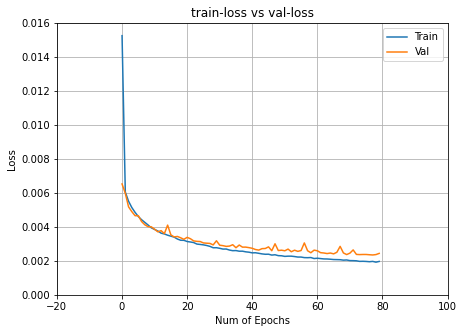

(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting


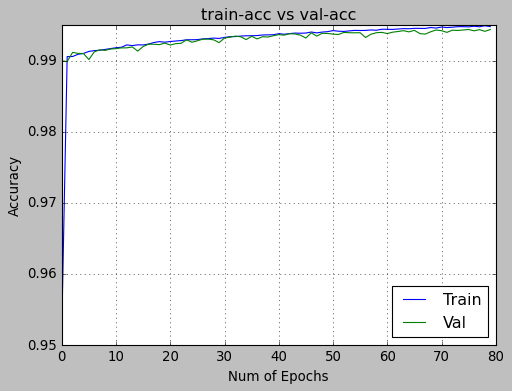

In [2]:
import datetime
import json
import os

no_tests = 1
epoch_num = 80 # 80 #18 #240
loss_name = 'focal' # 'loss'
for i in range(no_tests):
    print('################################################')
    print('Test number %d' % i)
    backend.clear_session()
    model = make_model(input_shape, n_classes, filter_size, kernel_size, pool_size) # reset model each time
    trained_weights = outfile = os.path.join('2DFCN2ECCV.h5')
    if os.path.exists(outfile):
        model.load_weights(trained_weights)
        print('Load trained weights')
    if loss_name.lower() == 'loss':
        model.compile(optimizer=opt, loss=loss, metrics=metrics)
    elif loss_name.lower() == 'focal':
        model.compile(optimizer=opt, loss=focal_loss(alpha=.25, gamma=2), metrics=metrics)
#        model.compile(optimizer=opt, loss=focal_loss, metrics=metrics)

    history = model.fit(X_train, y_train, epochs= epoch_num, validation_data=(X_test,y_test),verbose = 1,batch_size=1)


    # In[24]:


    
    currentDT = datetime.datetime.now()
    dt_str = currentDT.strftime("%Y-%m-%d_%H-%M-%S")
    #model_fname = '%s_%s_%s_%s.h5' % (NETWORK, WORK_ON, loss_name, dt_str)
    model_fname = '2DFCN2ECCV.h5'
    # save model
    model.save(model_fname)
    print('Saved model to ' + model_fname)
    # load model
    #model = load_model(model_fname)


    # In[17]:


    train_loss=history.history['loss']
    val_loss=history.history['val_loss']
    train_acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    xc=range(epoch_num)

    
    out_dic = {'train_loss': [str(num) for num in train_loss],
               'val_loss': [str(num) for num in val_loss],
               'train_acc': [str(num) for num in train_acc],
               'val_acc': [str(num) for num in val_acc],
               'epoch': [int(num) for num in xc]
               }
    history_fname = '%s_%s_%s_%s_history.json' % (NETWORK, WORK_ON, loss_name, dt_str)
    with open(history_fname, 'w') as fp:
        fp.write(json.dumps(out_dic, indent=4, sort_keys=True))

    fig = plt.figure(1,figsize=(7,5))
    fig.clf()
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('Num of Epochs')
    plt.ylabel('Loss')
    plt.title('train-loss vs val-loss')
    plt.grid(True)
    plt.legend(['Train','Val'])
    plt.style.use(['classic'])
#    plt.xlim([0, epoch_num])
#    plt.ylim([0, 1])
    fig1_fname = '%s_%s_%s_%s_fig1.png' % (NETWORK, WORK_ON, loss_name, dt_str)
    plt.savefig(fig1_fname, dpi=300)

    fig2 = plt.figure(2,figsize=(7,5))
    fig2.clf()
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('Num of Epochs')
    plt.ylabel('Accuracy')
    plt.title('train-acc vs val-acc')
    plt.grid(True)
    plt.legend(['Train','Val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])
#    plt.xlim([0, epoch_num])
#    plt.ylim([0, 1])
    fig2_fname = '%s_%s_%s_%s_fig2.png' % (NETWORK, WORK_ON, loss_name, dt_str)
    plt.savefig(fig2_fname, dpi=300)


    # # Evaluation

    # In[25]:


    prediction = model.predict(X_test,batch_size = 1)

    from sklearn.metrics import classification_report
    prediction.shape
    print(classification_report(y_test.argmax(axis=2).flatten(),prediction.argmax(axis=2).flatten()))
    report_fname = '%s_%s_%s_%s_report.txt' % (NETWORK, WORK_ON, loss_name, dt_str)
    with open(report_fname, 'w') as fp:
        fp.write(classification_report(y_test.argmax(axis=2).flatten(),prediction.argmax(axis=2).flatten()))


    # In[26]:


    #Shows a random pred-true-image pair.
    #show_data(X_test,y_test,prediction)


    # In[33]:


    #Save compare pairs to folders
    def save_predictions(X,Y_true,Y_pred,path):
        #de-one-hot
        Y_true = np.array(Y_true.argmax(axis=2) * 255,dtype=np.uint8)
        Y_pred = np.array(Y_pred.argmax(axis=2) * 255,dtype=np.uint8)
        for n in range(len(X_test)):
            images,msk = X[n],Y_true[n]
            msk_pred = Y_pred[n]
            cv2.imwrite(path + str(n)+'_img.jpg',images[-1])
            cv2.imwrite(path + str(n)+'_true.jpg',msk.reshape(image_shape[0:2]))
            cv2.imwrite(path + str(n)+'_pred.jpg',msk_pred.reshape(image_shape[0:2]))
    
    os.makedirs('Dataset/result_pair_'+NETWORK+'_'+WORK_ON+'/'+dt_str+'/')
    save_predictions(X_test,y_test,prediction, 'Dataset/result_pair_'+NETWORK+'_'+WORK_ON+'/'+dt_str+'/')
